In [ ]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import time
import random

import torch
import torchvision

from torch import nn
from torch.utils.data import DataLoader
from torch.optim import Adam

from torchvision import transforms, datasets
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
from timeit import default_timer as timer
from typing import Dict, List
import torch
print("Torch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)


Torch version: 2.2.1+cu121
Torchvision version: 0.17.1+cu121


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

100% 2.69G/2.70G [00:34<00:00, 136MB/s]
100% 2.70G/2.70G [00:34<00:00, 83.1MB/s]


In [ ]:
!unzip /content/new-plant-diseases-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/273a7a9e-18be-4b6a-976a-fa5ffd69b731___RS_HL 4366_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665_270deg.JPG  
  inflating: new plant diseases dataset(augmented)/New 

In [ ]:
# try to get torch info, install it if it does not work
try:
    from torchinfo import summary
    print("[INFO] torchinfo imported successfully")
except:
    print("[INFO] Could not find torchinfo. Installing it.")
    !pip install -q torchinfo
    from torchinfo import summary
    print("[INFO] torchinfo installed and imported successfully.")

[INFO] Could not find torchinfo. Installing it.
[INFO] torchinfo installed and imported successfully.


In [ ]:
# setting device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# access the dataset directory
dataset_dir = Path('/content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)')

print(dataset_dir)

/content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)


In [ ]:
# access train and validation directory
train_dir = dataset_dir / "train"
val_dir = dataset_dir / "valid"
test_dir = Path('/content/test/test')

print(f"Train Directory : {train_dir}")
print(f"Validation Directory : {val_dir}")
print(f"Test Directory : {test_dir}")

Train Directory : /content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train
Validation Directory : /content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid
Test Directory : /content/test/test


In [ ]:
total_class_train = len(os.listdir(train_dir))
total_class_val = len(os.listdir(val_dir))
total_test = len(os.listdir(test_dir))

print(f"Total of Train Data Classes: {total_class_train} classes")
print(f"Total of Validation Data Classes: {total_class_val} classes")
print(f"Total of Test Data: {total_test} images")

Total of Train Data Classes: 38 classes
Total of Validation Data Classes: 38 classes
Total of Test Data: 33 images


In [ ]:
# display data distribution
def count_data_per_class(path):
    classes = sorted(os.listdir(path))
    class_counts = {}
    for cls in classes:
        class_path = os.path.join(path, cls)
        class_counts[cls] = len(os.listdir(class_path))
    return class_counts

# calculate total data of each class
train_class_counts = count_data_per_class(train_dir)
val_class_counts = count_data_per_class(val_dir)

# create dataframe class count
train_counts_df = pd.DataFrame.from_dict(train_class_counts, orient="index", columns=["Count"])
val_counts_df = pd.DataFrame.from_dict(val_class_counts, orient="index", columns=["Count"])

In [ ]:
# total image for training and validation

print(f"Total Image for Training: {sum(train_class_counts.values())} images")
print(f"Total Image for Validation: {sum(val_class_counts.values())} images")

Total Image for Training: 70295 images
Total Image for Validation: 17572 images


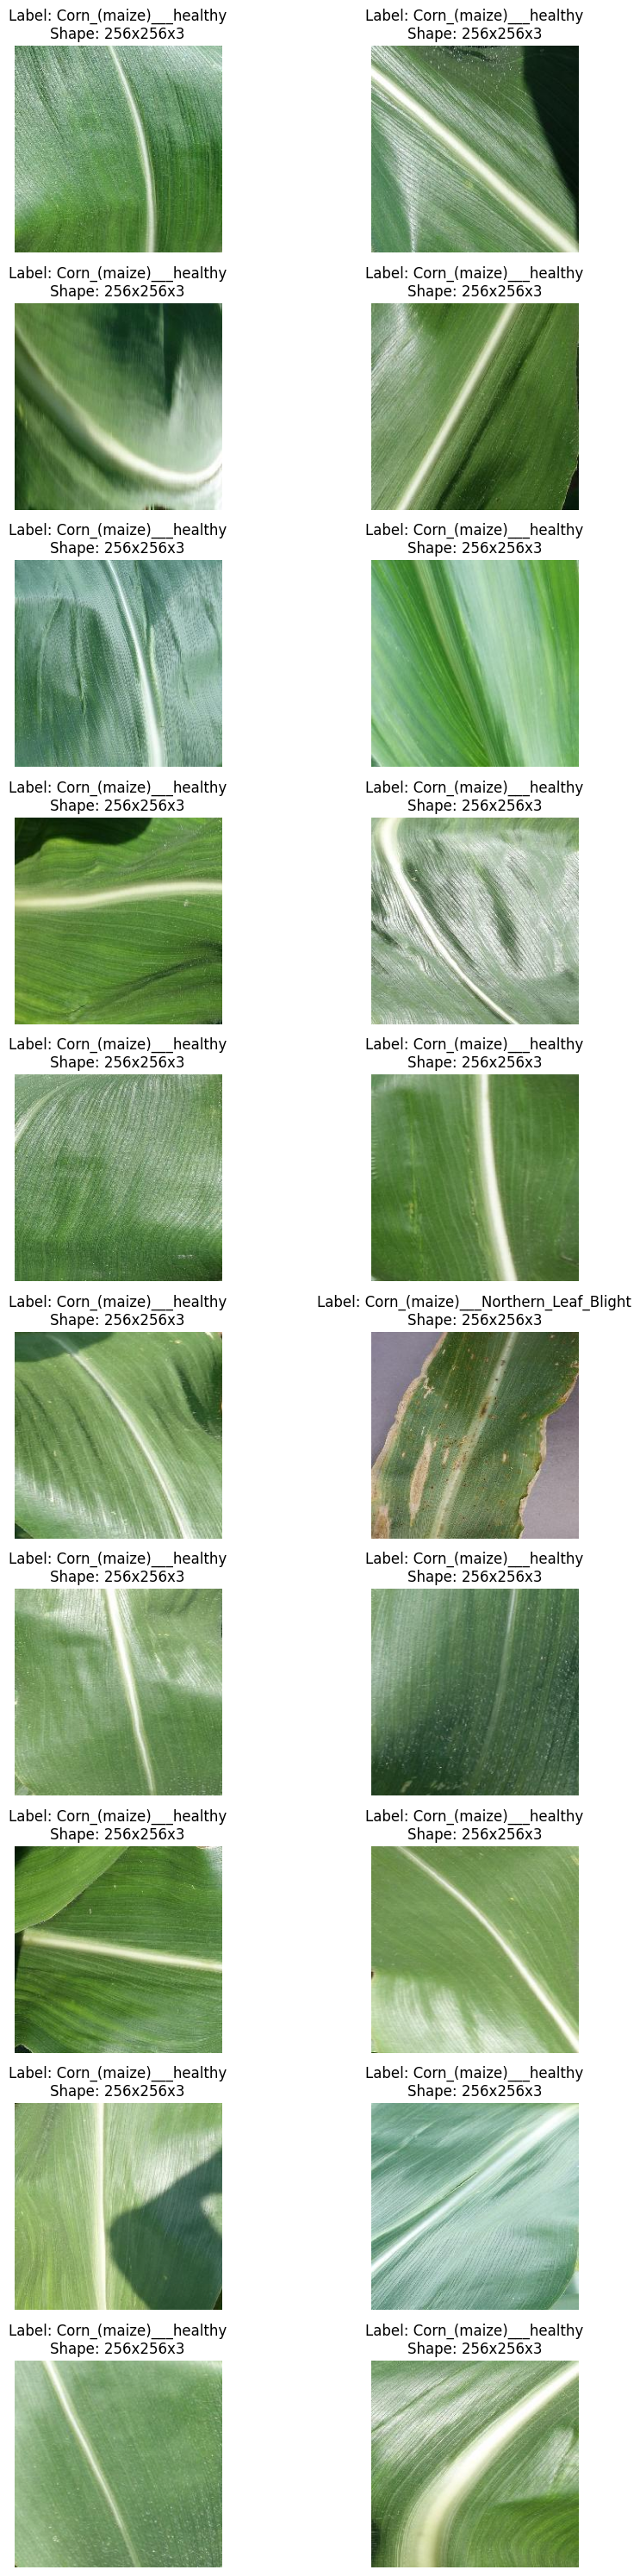

In [ ]:
# display some images
random.seed(33)

# get all of the image paths
image_path_list = list(dataset_dir.glob("*/*/*.jpg"))

# choose 20 images paths randomly
random_image_paths = random.sample(image_path_list, 20)

# define the subplot
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(10, 30))

# display 20 images randomly
for i, ax in enumerate(axes.flat):
    random_image_path = random_image_paths[i] # get image path
    image_class = random_image_path.parent.stem # get image class from path name as label
    image = Image.open(random_image_path) # open image
    ax.imshow(image) # display image on subplot

    # add label and shape of image
    ax.set_title(f"Label: {image_class}\nShape: {image.height}x{image.width}x{3 if image.mode == 'RGB' else 1}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
 # create data transformation based on ResNet50 model (ResNet50_Weights.IMAGENET1K_V2)
train_transform_rn50 = transforms.Compose([
    transforms.Resize(size=232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=224),
    transforms.RandomRotation(45), # augmentation: random rotation 45 degree
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform_rn50 = transforms.Compose([
    transforms.Resize(size=232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=224),
    # do not augmentin validation data
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# create data transformation based on EfficientNet V2 model (EfficientNet_V2_S_Weights.IMAGENET1K_V1)
train_transform_ev2 = transforms.Compose([
    transforms.Resize(size=384, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=384),
    transforms.RandomRotation(45), # augmentation: random rotation 45 degree
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform_ev2 = transforms.Compose([
    transforms.Resize(size=384, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=384),
    # do not augment in validation data
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# create ImageFolder for prepare dataset
# this method is easier than custom dataset, because dataset has already split by folder train and validation

# ImageFolder for ResNet50 model
train_dataset_rn50 = datasets.ImageFolder(root=train_dir, transform=train_transform_rn50)
val_dataset_rn50 = datasets.ImageFolder(root=val_dir, transform=val_transform_rn50)

# ImageFolder for EfficientNet V2 model
train_dataset_ev2 = datasets.ImageFolder(root=train_dir, transform=train_transform_ev2)
val_dataset_ev2 = datasets.ImageFolder(root=val_dir, transform=val_transform_ev2)

# display classes of ImageFolder dataset
print(f"Dataset Classes: {len(train_dataset_ev2.classes)}\n")
train_dataset_ev2.classes

Dataset Classes: 38



['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [ ]:
# create DataLoader for ResNet50 model
train_dataloader_rn50 = DataLoader(train_dataset_rn50,
                                   batch_size=32,
                                   num_workers=2,
                                   shuffle=True)

val_dataloader_rn50 = DataLoader(val_dataset_rn50,
                                 batch_size=32,
                                 num_workers=2,
                                 shuffle=False) # do not shuffle on validation data

# create DataLoader for EfficientNet V2 model
train_dataloader_ev2 = DataLoader(train_dataset_ev2,
                                  batch_size=32,
                                  num_workers=2,
                                  shuffle=True)

val_dataloader_ev2 = DataLoader(val_dataset_ev2,
                                batch_size=32,
                                num_workers=2,
                                shuffle=False) # do not shuffle on validation data


print(f"Number of Train Dataloader: {len(train_dataloader_ev2)} batches")
print(f"Number of Validation Dataloader: {len(val_dataloader_ev2)} batches")

Number of Train Dataloader: 2197 batches
Number of Validation Dataloader: 550 batches


In [ ]:
# load pre-trained ResNet50 model: ResNet50_Weights.IMAGENET1K_V2
rn50_model = resnet50(weights=ResNet50_Weights.DEFAULT)

# modify fully connected layer
rn50_model.fc = nn.Sequential(nn.Linear(in_features=rn50_model.fc.in_features, out_features=38))

# freeze pre-trained layers
for param in rn50_model.parameters():
    param.requires_grad = False

# unfreeze fully connected layers
for param in rn50_model.fc.parameters():
    param.requires_grad = True

# put model into device
rn50_model = rn50_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 71.6MB/s]


In [ ]:
# display ResNet50 model summary
summary(model=rn50_model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 38]             --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [ ]:
# load pre-trained EfficientNet V2 model: EfficientNet_V2_S_Weights.IMAGENET1K_V1
ev2_model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)

# modify fully connected layer
ev2_model.classifier = nn.Sequential(nn.Linear(in_features=1280, out_features=38))

# freeze pre-trained layers
for param in ev2_model.parameters():
    param.requires_grad = False

# unfreeze fully connected layers
for param in ev2_model.classifier.parameters():
    param.requires_grad = True
# put model into device
ev2_model = ev2_model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:01<00:00, 49.0MB/s]


In [ ]:
# display EfficientNet V2 model summary
summary(model=ev2_model,
        input_size=(32, 3, 384, 384),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 384, 384]    [32, 38]             --                   Partial
├─Sequential (features)                                      [32, 3, 384, 384]    [32, 1280, 12, 12]   --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 384, 384]    [32, 24, 192, 192]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 384, 384]    [32, 24, 192, 192]   (648)                False
│    │    └─BatchNorm2d (1)                                  [32, 24, 192, 192]   [32, 24, 192, 192]   (48)                 False
│    │    └─SiLU (2)                                         [32, 24, 192, 192]   [32, 24, 192, 192]   --                   --
│    └─Sequential (1)                                        [32, 24, 192, 192]   [32, 

In [ ]:
# use CrossEntropyLoss() for multiclass classification task
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Adam optimizer
optim_rn50 = Adam(params=rn50_model.parameters(), lr=0.001)
optim_ev2 = Adam(params=ev2_model.parameters(), lr=0.001)

In [ ]:
# train loop function
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # put model in train mode
    model.train()

    # setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # send data to target device
        X, y = X.to(device), y.to(device)

        # 1. forward pass
        y_pred = model(X)
# 2. calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backward
        loss.backward()

        # 5. optimizer step
        optimizer.step()

        # 6. calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
# validation loop test
def val_step(model: torch.nn.Module,
                    dataloader: torch.utils.data.DataLoader,
                    loss_fn: torch.nn.Module):
    # put model in eval mode
    model.eval()

    # setup test loss and test accuracy values
    val_loss, val_acc = 0, 0

    # turn on inference context manager
    with torch.inference_mode():
        # loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # send data to target device
            X, y = X.to(device), y.to(device)

            # 1. forward pass
            val_pred_logits = model(X)
            # 2. calculate and accumulate loss
            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

            # 3. calculate and accumulate accuracy
            val_pred_labels = val_pred_logits.argmax(dim=1)
            val_acc += ((val_pred_labels == y).sum().item()/len(val_pred_labels))

    # adjust metrics to get average loss and accuracy per batch
    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)
    return val_loss, val_acc

In [ ]:
# train process

# 1. take in various parameters required for training and test steps
def train_process(model: torch.nn.Module,
                  train_dataloader: torch.utils.data.DataLoader,
                  val_dataloader: torch.utils.data.DataLoader,
                  optimizer: torch.optim.Optimizer,
                  loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
                  epochs: int = 5):

    # 2. create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }
# 3. loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        val_loss, val_acc = val_step(model=model,
                                     dataloader=val_dataloader,
                                     loss_fn=loss_fn)

        # 4. print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"val_loss: {val_loss:.4f} | "
            f"val_acc: {val_acc:.4f}"
        )

        # 5. update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    # 6. return the filled results at the end of the epochs
    return results

In [ ]:
# set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set number of epochs
NUM_EPOCHS = 5

# start the timer
start_time = timer()

# train fine tuning ResNet50 model
rn50_results = train_process(model=rn50_model,
                             train_dataloader=train_dataloader_rn50,
                             val_dataloader=val_dataloader_rn50,
                             optimizer=optim_rn50,
                             loss_fn=loss_fn,
                             epochs=NUM_EPOCHS)
# end the timer and print out how long it took
end_time = timer()
print(f"Total Training Time: {end_time-start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 0.5733 | train_acc: 0.8991 | val_loss: 0.2254 | val_acc: 0.9485
Epoch: 2 | train_loss: 0.1786 | train_acc: 0.9575 | val_loss: 0.1410 | val_acc: 0.9637
Epoch: 3 | train_loss: 0.1293 | train_acc: 0.9656 | val_loss: 0.1125 | val_acc: 0.9698
Epoch: 4 | train_loss: 0.1075 | train_acc: 0.9705 | val_loss: 0.1040 | val_acc: 0.9690
Epoch: 5 | train_loss: 0.0933 | train_acc: 0.9733 | val_loss: 0.0985 | val_acc: 0.9703
Total Training Time: 1802.197 seconds


In [ ]:
# set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set number of epochs
NUM_EPOCHS = 5

# start the timer
start_time = timer()

# train fine tuning ResNet50 model
ev2_results = train_process(model=ev2_model,
                            train_dataloader=train_dataloader_ev2,
                            val_dataloader=val_dataloader_ev2,
                            optimizer=optim_ev2,
                            loss_fn=loss_fn,
                            epochs=NUM_EPOCHS)
# end the timer and print out how long it took
end_time = timer()
print(f"Total Training Time: {end_time-start_time:.3f} seconds")

NameError: name 'torch' is not defined

In [ ]:
# creat plot function for display result of training process
def plot_loss_curves(results: Dict[str, List[float]], suptitle=None, save="graph.jpg"):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # get the loss values of the results dictionary (training and validation)
    loss = results["train_loss"]
    val_loss = results["val_loss"]

    # get the accuracy values of the results dictionary (training and validation)
    accuracy = results["train_acc"]
    val_accuracy = results["val_acc"]

    # figure out how many epochs there were
    epochs = range(len(results["train_loss"]))

    # setup a plot
    plt.figure(figsize=(12, 4))

    # plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    plt.suptitle(suptitle)

    # save graph
    plt.savefig(save)

    plt.show()

In [ ]:
# plotting loss and accuracy from ResNet50 model results
plot_loss_curves(rn50_results, suptitle="Result of ResNet50", save="Result of ResNet50.jpg")

In [ ]:
# plotting loss and accuracy from EfficientNet V2 model results
plot_loss_curves(ev2_results, suptitle="Result of EfficientNet V2", save="Result of EfficientNet V2.jpg")

In [ ]:
# 1. create models directory
model_path = Path("/content/")
model_path.mkdir(parents=True, exist_ok=True)

# 2. create model save path
model_name = "01_plant_diseases_classification_pytorch_rn50.pth"
model_save_path = model_path / model_name

# 3. save the model state dict
print(f"Saving model to: {model_save_path}")
torch.save(obj=rn50_model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=model_save_path)

In [ ]:
# import torch
# import torchvision.models as models
# from torch2trt import torch2trt

# # ...

# # Save the model state dict
# print(f"Saving model to: {model_save_path}")
# torch.save(obj=rn50_model.state_dict(), f=model_save_path)

# # Load the model
# loaded_model = models.resnet50(pretrained=False)
# state_dict = torch.load(model_save_path)
# loaded_model.load_state_dict(state_dict)

# # Convert the model to TensorRT format
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# loaded_model = loaded_model.to(device)
# dummy_input = torch.randn(1, 3, 224, 224).to(device)
# trt_model = torch2trt(loaded_model, [dummy_input])

# # Save the TensorRT model as .h5
# h5_save_path = model_path / "model.h5"
# torch.save(trt_model.state_dict(), h5_save_path)

In [ ]:
# making prediction on single image

# load the trained ResNet50 model
# do not put model into device
path_model = "/content/01_plant_diseases_classification_pytorch_rn50.pth"
model = resnet50(weights=None)
model.fc = nn.Sequential(nn.Linear(in_features=model.fc.in_features, out_features=38))
model.load_state_dict(torch.load(path_model))
model.eval()

# define class labels
class_labels = train_dataset_rn50.classes

# define the transfomation for the test images (same as transformation for validation data)
preprocess = transforms.Compose([transforms.Resize(size=232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=224),
    # do not augment in test data
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# prediction function on single image
def predict_image(image_path, model):
    # open and preprocess the image
    image = Image.open(image_path)
    image_tensor = preprocess(image)
    image_tensor = image_tensor.unsqueeze(0)  # add batch dimension

    # make predictionwith torch.no_grad():
    outputs = model(image_tensor)
    _, predicted = torch.max(outputs, 1)
    confidence = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
    predicted_label = class_labels[predicted.item()]

    # display the image with prediction and confidence
    plt.imshow(image)
    plt.title(f"Prediction: {predicted_label}, Confidence: {confidence[predicted.item()]:.2f}%")
    plt.axis("off")
    plt.show()

In [ ]:
# apple cedar rust prediction
image_path = "/content/test/test/AppleCedarRust4.JPG"
predict_image(image_path, model)

In [ ]:
# apple scab prediction
image_path = "/content/test/test/AppleScab2.JPG"
predict_image(image_path, model)

In [ ]:
# corn common rust prediction
image_path = "/content/test/test/CornCommonRust1.JPG"
predict_image(image_path, model)

In [ ]:
# potato early blight prediction
image_path = "/content/test/test/PotatoEarlyBlight3.JPG"
predict_image(image_path, model)

In [ ]:
# potato healthy prediction
image_path = "/content/test/test/PotatoHealthy1.JPG"
predict_image(image_path, model)

In [ ]:
# tomato early blight prediction
image_path = "/content/test/test/TomatoEarlyBlight5.JPG"
predict_image(image_path, model)

In [ ]:
# tomato yellow curl virus prediction
image_path = "/content/test/test/TomatoYellowCurlVirus6.JPG"
predict_image(image_path, model)

In [ ]:
# tomato healthy prediction
image_path = "/content/test/test/TomatoHealthy1.JPG"
predict_image(image_path, model)

In [ ]:
import torch
import torchvision.models as models
from tensorflow import keras

# Assuming you have a compiled PyTorch model named rn50_model

# 1. Define the path (same as your original code)
model_path = Path("/content/")
model_path.mkdir(parents=True, exist_ok=True)

# 2. Create model save path with .h5 extension
model_name = "01_plant_diseases_classification_pytorch_rn50.h5"
model_save_path = model_path / model_name

# 3. Convert the PyTorch model to a TensorFlow model
loaded_model = models.resnet50(pretrained=False)  # Load the model
state_dict = torch.load(model_save_path)  # Load the PyTorch model state dictionary
loaded_model.load_state_dict(state_dict)  # Load the state dictionary into the model

# 4. Save the TensorFlow model as an HDF5 file
print(f"Saving model to: {model_save_path}")
loaded_model.save(model_save_path)